# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
import math

#private hypothesis testing library
import hypotests

#Styling Setup
sns.set_context('talk')
sns.set_style('ticks')

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
def call_conversion(x):
    ''' 
    Helper function to change (1,0) values to (Yes,No)
    to plot with seaborn catagorical plots
    '''
    if x == 1:
        return 'Yes'
    else:
        return 'No'
data['call_convert'] = data.call.apply(call_conversion)

[]

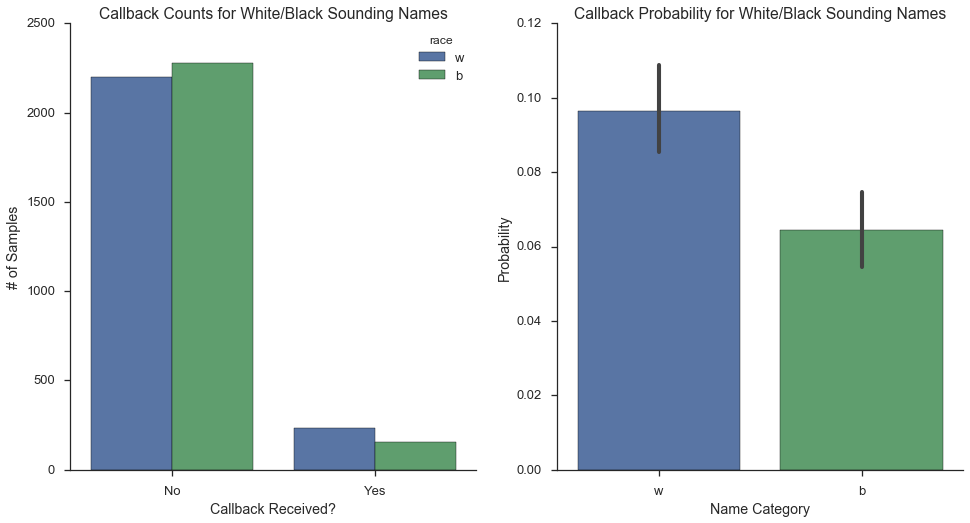

In [5]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(16)
# 1st Plot

sns.countplot(x="call_convert", hue='race', data=data,ax=ax1)
ax1.set_title("Callback Counts for White/Black Sounding Names")
ax1.set_xlabel("Callback Received?")
ax1.set_ylabel("# of Samples")
sns.despine(ax=ax1)

sns.barplot(x="race", y='call', data=data,ax=ax2)
ax2.set_title('Callback Probability for White/Black Sounding Names')
ax2.set_xlabel('Name Category')
ax2.set_ylabel('Probability')
sns.despine(ax=ax2)

plt.plot()

## Permutation Testing

Lets run a permutation test to see how likely it is for this difference in success rates to have occurred randomly. To do this we will use the *BinomialPermutationTest* class from my *hypotests* library. Lets walk through what it does below.

1. Calculate our actual test statistic. It is the absolute difference between the callback rates of white and black sounding names. $\left|\hat p_w-\hat p_b\right|$
2. Prepare the model by pooling together the callback data for both groups.
3. Run the model for however many specified iterations. Each iteration does the following:
  * Randomize the pool
  * Pull out two groups of equal sizes to the original white and black sounding names
  * Calculate the test statistic for these groups. $\left|\hat p_{g_1}-\hat p_{g_2}\right|$
  * Add the value to saved test data list
4. Determine the p-value by dividing the total number of iterations by the count of iterations that exceeded the stored actual test statistic.

If our p-value is > 0.05 then we can say there is a good enough probability that this difference in callback frequecies could have happened by chance and we fail to reject our null hypothesis. Otherwise, a sufficiently small p-value would indicate that it is very unlikely this difference happened by chance and therefore we should reject the null hypothesis.

Well in this case here is our null and alternative hypotheses:
$$H_0:p_w=p_b$$
$$H_A:p_w \neq p_b$$

Below we run the permutation test as described above:


In [6]:
w = list(data[data.race=='w'].call)
b = list(data[data.race=="b"].call)
test_data = (w, b)
bpt = hypotests.BinomialPermutationTest(test_data)
p_value = bpt.p_value(iters=20000)
print 'p-value =', p_value
print 'actual =', bpt.actual
print 'ts max =', bpt.max_test_stat()

p-value = 0.0
actual = 0.0320328542094
ts max = 0.0312114989733


[]

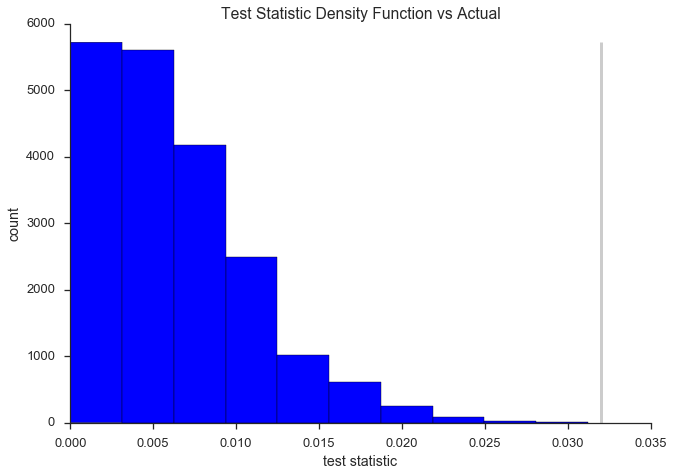

In [7]:
bpt.plot_hist()
plt.title('Test Statistic Density Function vs Actual')
sns.despine()
plt.plot()

Based on the data generated after 20,000 iterations we can safely say that the p-value is sufficiently small to reject the null hypothesis at the 95% confidence level. The difference we see in our sample callback frequencies between black and white sounding names is statistically significant.

## Parametric Testing
#### Binomial Approximation to the Normal Distribution


If we assume that our sample binomial distribution meets the criteria of the CLT then we can assume it follows the normal distribution and use a z score to estimate the significance between the two categories of success.

Similar to our permutation testing above our null and alternative hypothesis are as follows:

$$H_0:p_w=p_b$$
$$H_A:p_w \neq p_b$$

In [8]:
nw = float(len(w)) # Number of white sounding name samples
nb = float(len(b)) # Number of black sounding name samples
pw = sum(w)/nw     # probability of white sounding name getting a callback
pb = sum(b)/nb     # probability of black sounding name getting a callback

print "Prob white sounding name getting a callback:\t", pw
print "Prob black sounding name getting a callback:\t", pb
print "Number of white sounding name samples:\t\t", nw
print "Number of black sounding name samples:\t\t", nb


Prob white sounding name getting a callback:	0.0965092402464
Prob black sounding name getting a callback:	0.064476386037
Number of white sounding name samples:		2435.0
Number of black sounding name samples:		2435.0


Therefore:

| Variable | Value    |
|:--------:|:--------:|
|$p_w$     | $0.0965$ |
|$p_b$     | $0.0645$ |
|$n_w$     | $2435$   |
|$n_p$     | $2435$   |

The z-score for a binomial approximation is calculated as follows:

$$z=\frac{\hat p_w-\hat p_b}{\sqrt{\hat p(1-\hat p)\left(\frac{1}{n_w}+\frac{1}{n_b}\right)}}$$

where $\hat p=\frac{n_w\hat p_w+n_b\hat p_b}{n_w+n_b}$

In [9]:
p_hat = ((nw * pw) + (nb * pb)) / (nw + nb)

z = (pw - pb) / (math.sqrt(p_hat * (1 - p_hat) * ((1 / nw) + (1 / nb))))

print "Calculated z-score:\t", z
print "Calculated p-value:\t", stats.norm.cdf(1-z)

Calculated z-score:	4.10841215243
Calculated p-value:	0.000940477776658


For our test we are looking for a confidence level of $95$%.

therefore $\alpha = 0.05$ and our critical z-score is $z_{\alpha/2}=1.96$ since our null hypothesis states the probabilities are equal and any significant absolute difference in probabilities would cause us to reject it this is a two-tailed z-test.

Since our **calculated z-score (4.1084)** is greater than our **critical z-score (1.96)** and our calculated **p-value (0.00094)** is significally small we can reject the null hypothesis and accept that $p_w\neq p_b$ like we did with our permutation testing.

Below we calculate the standard error for this data and a 95% confidence interval for our test statistic.



### Standard Error
$$\sigma_{\hat p_w - \hat p_b} = \sqrt{\frac{\hat p_w(1-\hat p_w)}{n_w}+\frac{\hat p_b(1-\hat p_b)}{n_b}}$$

In [10]:
se = math.sqrt(((pw*(1-pw))/nw)+((pb*(1-pb))/nb))

print "Standard Error:", se

Standard Error: 0.00778337058668


### Confidence Interval
$$(\hat p_w - \hat p_b) \pm z_{(1-\alpha /2)} \sqrt{\frac{\hat p_w(1-\hat p_w)}{n_w}+\frac{\hat p_b(1-\hat p_b)}{n_b}}$$
___
$$(\hat p_w - \hat p_b) \pm z_{(1-\alpha /2)} * SE$$


In [12]:
ci = (((pw-pb)-(1.96*se)),((pw-pb)+(1.96*se)))

print '95% CI: ', ci

95% CI:  (0.016777447859559147, 0.047288260559332024)


So based on all the calculations and tests we have done so far, we are confident that if this study was conducted again, 95% of the time the difference in the callback frequencies between black and white sounding names will be between 1.68% and 4.73%.

Based on this sample of the population of employers in boston or chicago that are actively hiring, we can say that if you are looking for a job in these cities having a white sounding name will give you an edge while a black sounding name will put you at a disadvantage. 

Is this the most important factor considered by hiring managers at these firms? Not necessarily, but if all things are equal (as was structured for this experiment) our statements about how white or black your name is perceived to be will be a determining factor in your job hunt.